In [42]:
# load the package
include("../FractionalFlow/FractionalFlow.jl")
using PyPlot, SetPyPlot, NLopt, Dierckx
import Calculus
import GR
FF = FractionalFlow

FractionalFlow

# Water-flooding

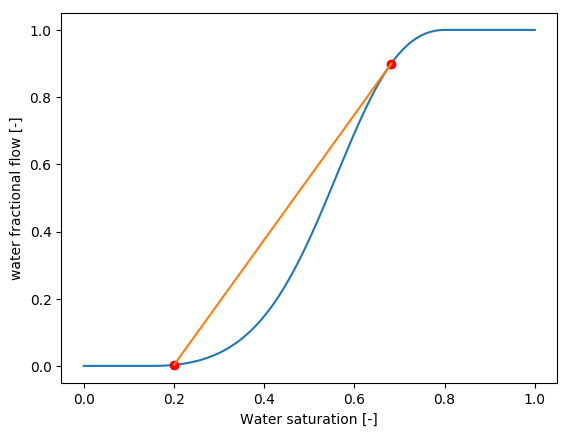

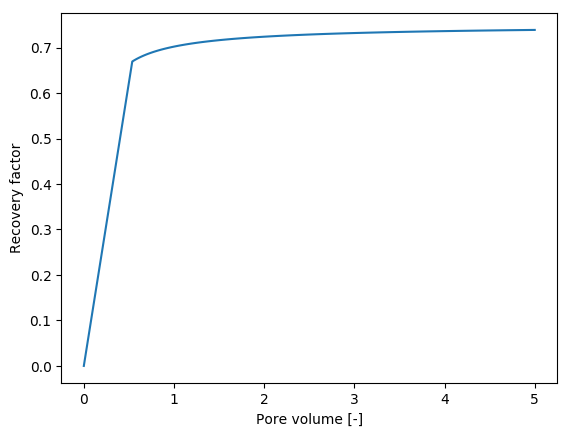

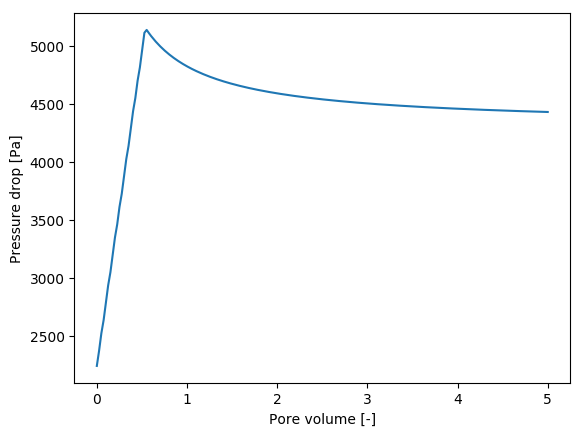

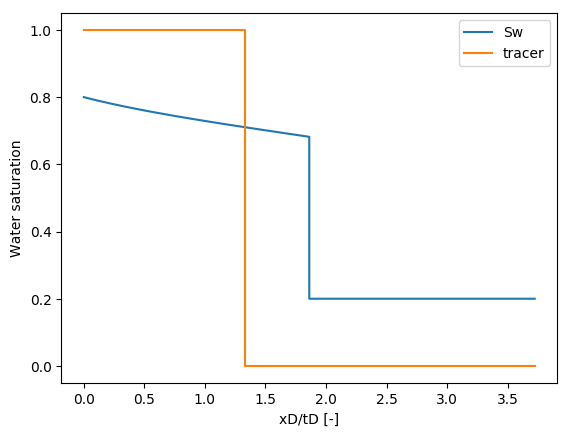

PyObject <matplotlib.legend.Legend object at 0x7fdee9ffaf50>

In [43]:
# define the problem
# relative permeabilities
rel_perms = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
    swc=0.15, sor=0.2, nw=2.0, no = 2.0)
# FF.visualize(rel_perms)
# define the fluids
fluids = FF.oil_water_fluids(mu_water=1e-3, mu_oil=1e-3)

# define the fractional flow functions
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
# visualize the fractional flow
# FF.visualize(rel_perms, fluids, label="lowsal")
# tight_layout()
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=5, 
    p_back=1e5, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms)
core_props = FF.core_properties()
wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
sw_tmp = linspace(0,1,100)

FF.visualize(wf_res)

In [44]:
# t_sec, pv, rec_fact, dp_core, x, sw, c, c_out_sal=
#             FF.water_flood_numeric(core_props, fluids, rel_perms, core_flood)

In [45]:
# figure()
# plot(t_sec, rec_fact, "o", wf_res.recovery_time[:,1], wf_res.recovery_time[:,2])
# figure()
# plot(t_sec, dp_core, "o", wf_res.dp_time[:,1], wf_res.dp_time[:,2])

# synthetic experimental data


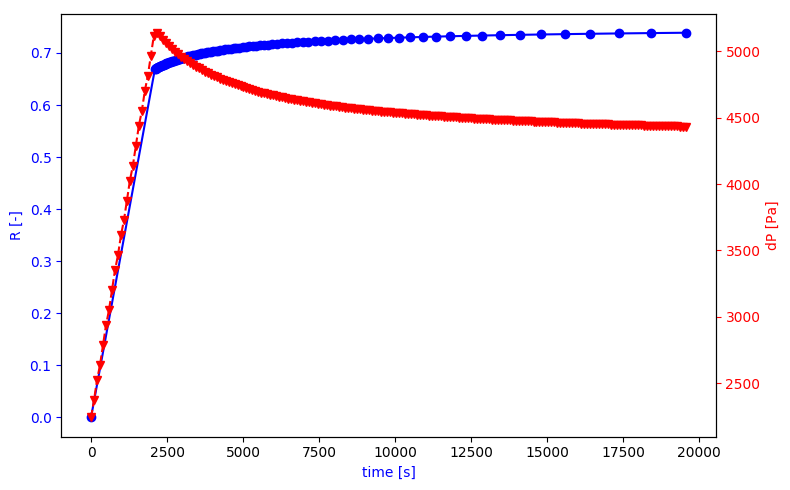

(PyPlot.Figure(PyObject <Figure size 800x500 with 2 Axes>), PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fdee9a30f50>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fdeeaaef910>)

In [46]:
t_exp_dp = wf_res.dp_time[:,1]
dp_exp = wf_res.dp_time[:,2]
t_exp_R = wf_res.recovery_time[:,1]
R_exp = wf_res.recovery_time[:,2]
plotyy(t_exp_R, R_exp, t_exp_dp, dp_exp, fig_size = [8,5], x_label="time [s]", y1_label="R [-]", y2_label="dP [Pa]")

# define the objective function

In [47]:
# struct
struct exp_data
    t_exp_dp
    dp_exp
    t_exp_R
    R_exp
end
exp_data1 = exp_data(t_exp_dp, dp_exp, t_exp_R, R_exp)

exp_data(Real[0.0, 98.3177, 196.635, 294.953, 393.271, 491.588, 589.906, 688.224, 786.541, 884.859  …  18680.4, 18778.7, 18877.0, 18975.3, 19073.6, 19171.9, 19270.3, 19368.6, 19466.9, 19565.2], Real[2242.5, 2373.63, 2523.48, 2637.26, 2786.82, 2936.46, 3050.13, 3199.71, 3349.32, 3462.97  …  4436.68, 4436.06, 4435.44, 4434.84, 4434.23, 4433.64, 4433.05, 4432.46, 4431.88, 4431.31], Real[0.0, 2102.05, 2123.61, 2145.64, 2168.16, 2191.17, 2214.69, 2238.73, 2263.31, 2288.44  …  12317.7, 12863.9, 13456.0, 14100.1, 14803.1, 15573.4, 16421.2, 17358.6, 18400.4, 19565.2], Real[0.0, 0.669421, 0.670104, 0.670788, 0.671473, 0.67216, 0.672849, 0.673539, 0.674231, 0.674924  …  0.732803, 0.733483, 0.734162, 0.734839, 0.735515, 0.736189, 0.736862, 0.737533, 0.738203, 0.738871])

In [48]:
core_flood.initial_water_saturation

0.2

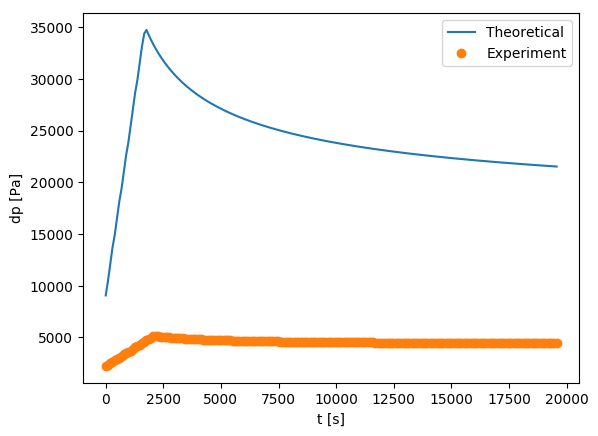

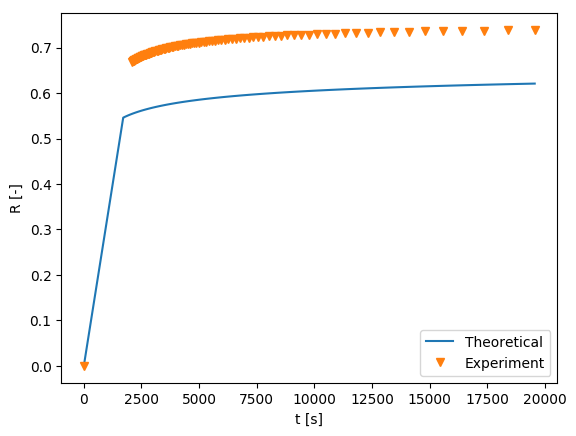

4.031308475396911

In [70]:
"""
rel_perm_param [krw0, kro0, nw, no, swc, sor]
"""
function error_calc(rel_perm_param, exp_data, core_props, fluids, core_flood; w_p=1.0, w_R=1.0)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    dp_calc = Spline1D(wf_res.dp_time[:,1], wf_res.dp_time[:,2], k=1, bc="nearest")
    R_calc = Spline1D(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], k=1, bc="nearest")
    error_dp = abs.(dp_calc(exp_data.t_exp_dp) .- exp_data.dp_exp)
#     println(error_dp)
    error_R = abs.(R_calc(exp_data.t_exp_R) .- exp_data.R_exp)
#     println(error_R)
    error_dp_norm = w_p.*error_dp./maximum(exp_data.dp_exp)
    error_R_norm = w_R.*error_R./maximum(exp_data.R_exp)
    return mean(error_R_norm)+mean(error_dp_norm)
end

function vis_error(rel_perm_param, exp_data, core_props, fluids, core_flood)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    figure()
    plot(wf_res.dp_time[:,1], wf_res.dp_time[:,2],  exp_data.t_exp_dp, exp_data.dp_exp, "o")
    xlabel("t [s]")
    ylabel("dp [Pa]")
    legend(["Theoretical", "Experiment"])
    
    figure()
    plot(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], exp_data.t_exp_R, exp_data.R_exp, "v")
    xlabel("t [s]")
    ylabel("R [-]")
    legend(["Theoretical", "Experiment"])
    
end

# test
x_init = [0.109681, 0.201297, 3.96653, 3.0, 0.19, 0.262231]

vis_error(x_init, exp_data1, core_props, fluids, core_flood)
error_calc(x_init, exp_data1, core_props, fluids, core_flood)

# define the objective function and gradients and weight factors

In [78]:
# weight factors:
w_p = ones(length(exp_data1.dp_exp))
ind_max = indmax(exp_data1.dp_exp)
w_p[ind_max-1:ind_max+2] = 10
w_p[end]=10
w_p[1]=10
w_R = ones(length(exp_data1.R_exp))
w_R[2] = 10
w_R[end:end-3]=10


function f(x)
    f_val = 0.0
    try
        f_val = error_calc(x, exp_data1, core_props, fluids, core_flood, w_p = w_p, w_R = w_R)
    catch
        f_val = 100.0
#         info("Objective function did not converge!")
    end
    return f_val
end

    
function g(x)
    eps1 = 1e-4
    f_val = f(x)
    g_val = ones(length(x))
    try
        # g_val = Calculus.gradient(x -> error_calc(x, exp_data1, core_props, fluids, core_flood), x)
        for j in eachindex(x)
            x2 = copy(x)
            x2[j]+=eps1
            f_val2 = f(x2)
            g_val[j] = (f_val2-f_val)/eps1
        end
    catch
        g_val = ones(length(x))
    end
    return g_val
end

function obj_fun(param, grad)
    if length(grad)>0
      grad[:] = g(param)
    end
    
    obj_fun_val = f(param)
    if isnan(obj_fun_val) || isinf(obj_fun_val)
        obj_fun_val = 100.0
    end
    return obj_fun_val
end

# test
grad_x = zeros(6)
obj_fun([1.0, 0.8, 3, 4, 0.2, 0.2], grad_x)

f([1.0, 0.8, 2, 2, 0.1, 0.2])

0.679188251524736

In [52]:
grad_x

6-element Array{Float64,1}:
  0.427935  
  0.00634015
 -0.0981347 
 -0.0587916 
 -0.495143  
  1.30446   

In [53]:
## algorithms
# L: Local, G:global
# D: derivative-based, N: non-derivative (search-based)

# :LD_MMA
# :LN_COBYLA
# :LD_LBFGS
# :GN_DIRECT
# :GN_DIRECT_L
# GN_CRS2_LM
# G_MLSL_LDS
# GD_STOGO
# GN_ISRES
# GN_ESCH
# LN_NEWUOA_BOUND
# LN_BOBYQA
# LN_PRAXIS
# LN_NELDERMEAD
# LN_SBPLX
# LD_SLSQP
# LD_TNEWTON_PRECOND_RESTART
# LD_TNEWTON_RESTART
# LD_TNEWTON_PRECOND


In [ ]:
x_init = [0.9, 0.8, 2.5, 2.5, 0.15, 0.15]
x_lb = [0.1, 0.1, 1.5, 1.5, 0.05, 0.1]
x_ub = [1.0, 1.0, 4.0, 4.0, core_flood.initial_water_saturation, 0.25]
opt_alg=:GN_ISRES
opt1 = Opt(opt_alg, length(x_init)) # choose the algorithm
lower_bounds!(opt1, x_lb)
upper_bounds!(opt1, x_ub)
ftol_rel!(opt1, 1e-15)
ftol_abs!(opt1, 1e-15)

min_objective!(opt1, obj_fun)
(fObjOpt, paramOpt, flag) = optimize(opt1, x_init)

INFO: Outlet saturation is estimated: 0.7622271865811191, error is 2.1885134277190836
INFO: Outlet saturation is estimated: 0.8046234035733253, error is 2.1306187514443926
INFO: Outlet saturation is estimated: 0.7792436960435936, error is 2.559334098333522
INFO: Outlet saturation is estimated: 0.7937482845232343, error is 3.5577693686525267
INFO: Outlet saturation is estimated: 0.8523154837246536, error is 1.6468329678406373
INFO: Outlet saturation is estimated: 0.7907526996406652, error is 1.758866355934161
INFO: Outlet saturation is estimated: 0.801525855683612, error is 1.8338809769160815
INFO: Outlet saturation is estimated: 0.8840704106084677, error is 3.6126457265997383
INFO: Outlet saturation is estimated: 0.8523773847693151, error is 1.9802843455073398
INFO: Outlet saturation is estimated: 0.845017906048106, error is 2.8998224931060075
INFO: Outlet saturation is estimated: 0.8384547354329892, error is 2.614404356187963
INFO: Outlet saturation is estimated: 0.870882674960033, er

INFO: Outlet saturation is estimated: 0.7566791699117122, error is 3.2873621654616674
INFO: Outlet saturation is estimated: 0.8210963037253132, error is 2.3902668982661734
INFO: Outlet saturation is estimated: 0.7882936868558383, error is 4.197128830875892
INFO: Outlet saturation is estimated: 0.7694087295291101, error is 1.2115511282120552
INFO: Outlet saturation is estimated: 0.757445281827465, error is 4.224127434287848
INFO: Outlet saturation is estimated: 0.818426476622973, error is 2.470072621477969
INFO: Outlet saturation is estimated: 0.7447505674371293, error is 3.734316071057485
INFO: Outlet saturation is estimated: 0.8026261238657473, error is 0.7325992273160891
INFO: Outlet saturation is estimated: 0.7990839162529326, error is 0.3727680632342567
INFO: Outlet saturation is estimated: 0.8362936018488105, error is 2.136588844466429
INFO: Outlet saturation is estimated: 0.7850842891048828, error is 2.326191868817251
INFO: Outlet saturation is estimated: 0.8405619901246557, erro

INFO: Outlet saturation is estimated: 0.7961834967170978, error is 3.28833783798642
INFO: Outlet saturation is estimated: 0.7988281884386648, error is 2.595126448447611
INFO: Outlet saturation is estimated: 0.7973180984618475, error is 1.2666068989281105
INFO: Outlet saturation is estimated: 0.8010986626346799, error is 1.0793273628666746
INFO: Outlet saturation is estimated: 0.8576409888753691, error is 1.6986792911959538
INFO: Outlet saturation is estimated: 0.86634428309532, error is 2.5092402741898194
INFO: Outlet saturation is estimated: 0.7602918578557379, error is 3.916366815144222
INFO: Outlet saturation is estimated: 0.7521531523202669, error is 4.211547816505565
INFO: Outlet saturation is estimated: 0.798701599582827, error is 2.0511615059629578
INFO: Outlet saturation is estimated: 0.7857815900374047, error is 0.8019425958046318
INFO: Outlet saturation is estimated: 0.7929338761867726, error is 3.343294335931732
INFO: Outlet saturation is estimated: 0.8003705219490036, error

INFO: Outlet saturation is estimated: 0.8826192001244797, error is 1.3883171070353009
INFO: Outlet saturation is estimated: 0.7618312043346667, error is 0.9316382175786293
INFO: Outlet saturation is estimated: 0.7711952802409234, error is 0.5608530386388022
INFO: Outlet saturation is estimated: 0.8546644500646476, error is 2.322609165127278
INFO: Outlet saturation is estimated: 0.8884564864548878, error is 3.005060489144019
INFO: Outlet saturation is estimated: 0.7776757908338572, error is 2.0360148020353694
INFO: Outlet saturation is estimated: 0.8610822681489854, error is 2.170445831837642
INFO: Outlet saturation is estimated: 0.8065359434502917, error is 0.7666978676711844
INFO: Outlet saturation is estimated: 0.7725579441768882, error is 0.6282474792814643
INFO: Outlet saturation is estimated: 0.8797672963914457, error is 3.3515559014654586
INFO: Outlet saturation is estimated: 0.8423350132296938, error is 3.1517513305771265
INFO: Outlet saturation is estimated: 0.8186936623660213,

INFO: Outlet saturation is estimated: 0.8094237841758798, error is 0.5395861797509935
INFO: Outlet saturation is estimated: 0.8528229724784385, error is 0.5719793989422941
INFO: Outlet saturation is estimated: 0.8784011403049024, error is 1.7602072679074054
INFO: Outlet saturation is estimated: 0.8451225123036092, error is 2.50739657592482
INFO: Outlet saturation is estimated: 0.8415528200449074, error is 1.0732451924249427
INFO: Outlet saturation is estimated: 0.8640265999992951, error is 0.6795438128990874
INFO: Outlet saturation is estimated: 0.87970772563444, error is 3.8761086167941357
INFO: Outlet saturation is estimated: 0.7518655821453764, error is 1.2447429503622858
INFO: Outlet saturation is estimated: 0.8421948594896307, error is 1.6513398998618771
INFO: Outlet saturation is estimated: 0.8292410738575586, error is 1.125832439525487
INFO: Outlet saturation is estimated: 0.7409335843870228, error is 0.8091557659345927
INFO: Outlet saturation is estimated: 0.8606065882467829, e

INFO: Outlet saturation is estimated: 0.8274449500675654, error is 0.9819501984899102
INFO: Outlet saturation is estimated: 0.8479921828215405, error is 0.48827537772359886
INFO: Outlet saturation is estimated: 0.8305275382389776, error is 0.3479352093124781
INFO: Outlet saturation is estimated: 0.7421480885296731, error is 0.3611174055169597
INFO: Outlet saturation is estimated: 0.7992259513240524, error is 1.9231674335362747
INFO: Outlet saturation is estimated: 0.8143458643549139, error is 3.277999326338855
INFO: Outlet saturation is estimated: 0.7977112774290649, error is 0.5934874976677751
INFO: Outlet saturation is estimated: 0.8256946744713957, error is 2.2011324557168503
INFO: Outlet saturation is estimated: 0.8150400218653462, error is 0.6407462051598198
INFO: Outlet saturation is estimated: 0.7737918874443652, error is 1.5089842658730679
INFO: Outlet saturation is estimated: 0.832830722801455, error is 2.9086052496801726
INFO: Outlet saturation is estimated: 0.796874362928585

INFO: Outlet saturation is estimated: 0.7983170476526509, error is 3.0703404267516254
INFO: Outlet saturation is estimated: 0.8034528278483718, error is 2.4235227020340466
INFO: Outlet saturation is estimated: 0.8310811054214016, error is 1.5603464084808385
INFO: Outlet saturation is estimated: 0.7488395925864644, error is 3.515259737594412
INFO: Outlet saturation is estimated: 0.7561322522744721, error is 3.19154530598977
INFO: Outlet saturation is estimated: 0.7865952417122319, error is 0.8897066026224758
INFO: Outlet saturation is estimated: 0.7837571899297078, error is 0.003967407961591007
INFO: Outlet saturation is estimated: 0.8039834269076397, error is 2.454531934264008
INFO: Outlet saturation is estimated: 0.8187346289300743, error is 1.7017020298161252
INFO: Outlet saturation is estimated: 0.7443822469802135, error is 2.242139779058465
INFO: Outlet saturation is estimated: 0.8202682991295509, error is 2.0488465167975063
INFO: Outlet saturation is estimated: 0.7533149307159759,

INFO: Outlet saturation is estimated: 0.7866535737012774, error is 1.478465539176264
INFO: Outlet saturation is estimated: 0.7614978173424394, error is 0.887230876700718
INFO: Outlet saturation is estimated: 0.8427147006360272, error is 1.8946906269772632
INFO: Outlet saturation is estimated: 0.8016952069494311, error is 0.24083358626501639
INFO: Outlet saturation is estimated: 0.7415659067665932, error is 1.30097797840605
INFO: Outlet saturation is estimated: 0.7606844929492658, error is 0.593908174959866
INFO: Outlet saturation is estimated: 0.7984920660093073, error is 2.8969668781016047
INFO: Outlet saturation is estimated: 0.7765985527402228, error is 1.7118413304945643
INFO: Outlet saturation is estimated: 0.7819616734462638, error is 0.2358759046893164
INFO: Outlet saturation is estimated: 0.8211949358162858, error is 1.4655888146481084
INFO: Outlet saturation is estimated: 0.7800596040264611, error is 3.0656225451342802
INFO: Outlet saturation is estimated: 0.7606068626460647, 

INFO: Outlet saturation is estimated: 0.7546294907713124, error is 1.1999789522838546
INFO: Outlet saturation is estimated: 0.7805661716987005, error is 0.006816456671586479
INFO: Outlet saturation is estimated: 0.8229107854735953, error is 0.9283649505058804
INFO: Outlet saturation is estimated: 0.7809960895714215, error is 3.0574641155536275
INFO: Outlet saturation is estimated: 0.774652595262568, error is 1.4143871628693385
INFO: Outlet saturation is estimated: 0.7703258505498155, error is 2.7328336869080583
INFO: Outlet saturation is estimated: 0.7683452063607998, error is 1.2078227176343326
INFO: Outlet saturation is estimated: 0.7651150696807941, error is 0.9800586571556567
INFO: Outlet saturation is estimated: 0.7711097884198372, error is 1.6154688023695503
INFO: Outlet saturation is estimated: 0.7413515093846617, error is 0.24399596860787565
INFO: Outlet saturation is estimated: 0.7759950217082512, error is 3.0437979348115443
INFO: Outlet saturation is estimated: 0.799082105154

INFO: Outlet saturation is estimated: 0.7498213255770937, error is 0.5450730925892664
INFO: Outlet saturation is estimated: 0.7487890758816845, error is 0.3687383716285577
INFO: Outlet saturation is estimated: 0.7869027366791909, error is 2.9596377198259223
INFO: Outlet saturation is estimated: 0.7763468630525516, error is 1.669152546422859
INFO: Outlet saturation is estimated: 0.807793231355862, error is 3.255244212801998
INFO: Outlet saturation is estimated: 0.8306691183724866, error is 0.38513702659747384
INFO: Outlet saturation is estimated: 0.7756058573275875, error is 1.1272900073721992
INFO: Outlet saturation is estimated: 0.766763228454074, error is 2.7432500015757992
INFO: Outlet saturation is estimated: 0.7615861433807252, error is 0.21666827440602177
INFO: Outlet saturation is estimated: 0.797912207695231, error is 2.9367458289167936
INFO: Outlet saturation is estimated: 0.794089649081258, error is 1.8376016594233184
INFO: Outlet saturation is estimated: 0.7817270490465517, 

INFO: Outlet saturation is estimated: 0.7761148176139644, error is 2.5845038866583825
INFO: Outlet saturation is estimated: 0.7925357004736985, error is 2.5798226763055925
INFO: Outlet saturation is estimated: 0.7497408601826083, error is 2.278677267245965
INFO: Outlet saturation is estimated: 0.7952040630464636, error is 3.488691980928121
INFO: Outlet saturation is estimated: 0.8084332077849756, error is 1.7533656487680984
INFO: Outlet saturation is estimated: 0.7431349003267164, error is 0.13273146682787385
INFO: Outlet saturation is estimated: 0.790269259751237, error is 1.4375355047564757
INFO: Outlet saturation is estimated: 0.7664426240393161, error is 0.9389723463655333
INFO: Outlet saturation is estimated: 0.7502651874468981, error is 2.4837051890185453
INFO: Outlet saturation is estimated: 0.7910469113136912, error is 2.7532425849905793
INFO: Outlet saturation is estimated: 0.7644503034993642, error is 2.5882603782847298
INFO: Outlet saturation is estimated: 0.8055916640492051

INFO: Outlet saturation is estimated: 0.7461334236734743, error is 2.578162273094851
INFO: Outlet saturation is estimated: 0.7697635271436788, error is 1.171991928185589
INFO: Outlet saturation is estimated: 0.780066930514844, error is 2.228806159497
INFO: Outlet saturation is estimated: 0.7899509576680285, error is 1.2893479499124108
INFO: Outlet saturation is estimated: 0.849722955363614, error is 0.9670499072715897
INFO: Outlet saturation is estimated: 0.7534904617103592, error is 2.256993888741252
INFO: Outlet saturation is estimated: 0.7773161683147246, error is 2.490469668643087
INFO: Outlet saturation is estimated: 0.8396714904130795, error is 0.6488831063506897
INFO: Outlet saturation is estimated: 0.7501458231030793, error is 3.274692476027767
INFO: Outlet saturation is estimated: 0.7854018589493945, error is 1.3067146694191827
INFO: Outlet saturation is estimated: 0.7725990539960054, error is 2.890483862730802
INFO: Outlet saturation is estimated: 0.8232188118350284, error is

INFO: Outlet saturation is estimated: 0.7443128830634188, error is 1.5988929853365406
INFO: Outlet saturation is estimated: 0.7892923387953538, error is 1.6491950851597816
INFO: Outlet saturation is estimated: 0.7786158736233887, error is 2.234515037510308
INFO: Outlet saturation is estimated: 0.7818121677585432, error is 1.2863168372127687
INFO: Outlet saturation is estimated: 0.8033188052362417, error is 2.88518562974918
INFO: Outlet saturation is estimated: 0.7452825955601197, error is 2.084671014869886
INFO: Outlet saturation is estimated: 0.7650950094866812, error is 0.15238416482190953
INFO: Outlet saturation is estimated: 0.7849606924438395, error is 0.8135190991488352
INFO: Outlet saturation is estimated: 0.7963785137610898, error is 3.3572128105838765
INFO: Outlet saturation is estimated: 0.7701311727095912, error is 1.4713598031442392
INFO: Outlet saturation is estimated: 0.7953147406803602, error is 1.7669000966202297
INFO: Outlet saturation is estimated: 0.768645787730492, 

INFO: Outlet saturation is estimated: 0.7670196798993196, error is 1.8334069879996715
INFO: Outlet saturation is estimated: 0.7783445973011832, error is 0.22643529509166171
INFO: Outlet saturation is estimated: 0.7789325566924602, error is 3.674644779301727
INFO: Outlet saturation is estimated: 0.7727910600249608, error is 2.094410832788131
INFO: Outlet saturation is estimated: 0.7753153355691778, error is 2.6314978275266063
INFO: Outlet saturation is estimated: 0.7796749853204702, error is 3.214190667258327
INFO: Outlet saturation is estimated: 0.7453886771984116, error is 1.3120624542107224
INFO: Outlet saturation is estimated: 0.7606719263851363, error is 2.4502789548252024
INFO: Outlet saturation is estimated: 0.7551650232013662, error is 2.9376840396075172
INFO: Outlet saturation is estimated: 0.7741759831969015, error is 2.4189065921750275
INFO: Outlet saturation is estimated: 0.7733001523171129, error is 1.7529893665391576
INFO: Outlet saturation is estimated: 0.7773422961794401

INFO: Outlet saturation is estimated: 0.7995984171464802, error is 0.6420220286768012
INFO: Outlet saturation is estimated: 0.7774249732540225, error is 1.9341259753576483
INFO: Outlet saturation is estimated: 0.7621811172419524, error is 3.119517820477741
INFO: Outlet saturation is estimated: 0.8184680831054373, error is 3.246961110227789
INFO: Outlet saturation is estimated: 0.7578348884182894, error is 3.2275174164716134
INFO: Outlet saturation is estimated: 0.7965792015980133, error is 3.3826308314093403
INFO: Outlet saturation is estimated: 0.7879335833973657, error is 0.20900804455302957
INFO: Outlet saturation is estimated: 0.7816341151513644, error is 2.0777794359103527
INFO: Outlet saturation is estimated: 0.7495325710443976, error is 3.3205480368095928
INFO: Outlet saturation is estimated: 0.7410306677721732, error is 2.427952876639271
INFO: Outlet saturation is estimated: 0.774502204338237, error is 3.600739586190973
INFO: Outlet saturation is estimated: 0.7815767553454185, 

INFO: Outlet saturation is estimated: 0.7563474051625961, error is 2.535532362429093
INFO: Outlet saturation is estimated: 0.7934646168712213, error is 2.8689466934259618
INFO: Outlet saturation is estimated: 0.7661888647931895, error is 2.314408402887596
INFO: Outlet saturation is estimated: 0.8091343269342421, error is 2.3604371615633486
INFO: Outlet saturation is estimated: 0.749657865664124, error is 2.9348569482120705
INFO: Outlet saturation is estimated: 0.7596255915518182, error is 2.9318151087295905
INFO: Outlet saturation is estimated: 0.794549240930232, error is 3.2992474966362684
INFO: Outlet saturation is estimated: 0.7466371762884534, error is 1.1135077653775496
INFO: Outlet saturation is estimated: 0.7775679625105416, error is 1.448268325751696
INFO: Outlet saturation is estimated: 0.774009434759339, error is 2.681494337766107
INFO: Outlet saturation is estimated: 0.7787745031890121, error is 3.570304241553716
INFO: Outlet saturation is estimated: 0.7680464708001978, erro

INFO: Outlet saturation is estimated: 0.7878346142543243, error is 2.0112484866558336
INFO: Outlet saturation is estimated: 0.7819039290217785, error is 1.6160185922373786
INFO: Outlet saturation is estimated: 0.7786667477123203, error is 1.6711853871623066
INFO: Outlet saturation is estimated: 0.7478367146009457, error is 0.32490855332399526
INFO: Outlet saturation is estimated: 0.7897405126501025, error is 2.9724794598546462
INFO: Outlet saturation is estimated: 0.7871334629769395, error is 1.9483396240618576
INFO: Outlet saturation is estimated: 0.7697109936558071, error is 3.1189537671466336
INFO: Outlet saturation is estimated: 0.796025785446098, error is 0.1658944542166969
INFO: Outlet saturation is estimated: 0.768422592728627, error is 3.0953229834851914
INFO: Outlet saturation is estimated: 0.7521902103052538, error is 3.0087052155497007
INFO: Outlet saturation is estimated: 0.7507973884812927, error is 2.4309857580224077
INFO: Outlet saturation is estimated: 0.755276600207738

INFO: Outlet saturation is estimated: 0.7780371959001572, error is 0.523294738669196
INFO: Outlet saturation is estimated: 0.7447910942447052, error is 1.8113062994259597
INFO: Outlet saturation is estimated: 0.7678162339686386, error is 3.3373963437522702
INFO: Outlet saturation is estimated: 0.7636630495601423, error is 2.5527385648246215
INFO: Outlet saturation is estimated: 0.7841016167279161, error is 2.27968773720744
INFO: Outlet saturation is estimated: 0.7634294876029153, error is 3.5349059588667684
INFO: Outlet saturation is estimated: 0.7532378048535053, error is 2.5231427317303177
INFO: Outlet saturation is estimated: 0.7563815270098431, error is 1.8241116586289907
INFO: Outlet saturation is estimated: 0.7414048370059526, error is 3.2422264065623834
INFO: Outlet saturation is estimated: 0.7691203456101438, error is 0.5234416816208807
INFO: Outlet saturation is estimated: 0.7657657351880212, error is 0.25149893709625015
INFO: Outlet saturation is estimated: 0.7455479770104073

INFO: Outlet saturation is estimated: 0.7611914199293746, error is 2.932229354827115
INFO: Outlet saturation is estimated: 0.7871125049635392, error is 2.991105745471437
INFO: Outlet saturation is estimated: 0.7797681411864298, error is 3.4208820459648224
INFO: Outlet saturation is estimated: 0.7600637990473694, error is 2.743912442348223
INFO: Outlet saturation is estimated: 0.7570752871169006, error is 3.155904985319581
INFO: Outlet saturation is estimated: 0.7547356246645767, error is 3.431703321364691
INFO: Outlet saturation is estimated: 0.7513757472880361, error is 3.709152260144774
INFO: Outlet saturation is estimated: 0.7620849183595908, error is 0.5378420010731544
INFO: Outlet saturation is estimated: 0.7691163261580817, error is 3.167140076113203
INFO: Outlet saturation is estimated: 0.757877566793795, error is 3.3432904085656636
INFO: Outlet saturation is estimated: 0.7656364921396727, error is 1.6340608717314962
INFO: Outlet saturation is estimated: 0.7642480865372233, erro

INFO: Outlet saturation is estimated: 0.7756233626889941, error is 2.467030471200337
INFO: Outlet saturation is estimated: 0.7710492483406963, error is 0.09250415363537545
INFO: Outlet saturation is estimated: 0.7970954424874506, error is 2.270802015140632
INFO: Outlet saturation is estimated: 0.784015101267219, error is 3.6375475811702067
INFO: Outlet saturation is estimated: 0.7679516841319621, error is 2.722579187360663
INFO: Outlet saturation is estimated: 0.7589333690665033, error is 3.0184380776142095
INFO: Outlet saturation is estimated: 0.7460826262549898, error is 3.495231891566716
INFO: Outlet saturation is estimated: 0.7609444791136213, error is 2.6259535027045877
INFO: Outlet saturation is estimated: 0.7556601371188789, error is 2.7760104742079506
INFO: Outlet saturation is estimated: 0.754601768181025, error is 2.6976803984713005
INFO: Outlet saturation is estimated: 0.7577997348556836, error is 2.972106454911552
INFO: Outlet saturation is estimated: 0.7559341146724287, er

INFO: Outlet saturation is estimated: 0.7684612815862206, error is 3.5195442974592
INFO: Outlet saturation is estimated: 0.7750052950300693, error is 2.498537467963588
INFO: Outlet saturation is estimated: 0.7468862941176739, error is 3.706012582718773
INFO: Outlet saturation is estimated: 0.7601670130424043, error is 2.8123021866029636
INFO: Outlet saturation is estimated: 0.7619536885486744, error is 2.9451355567612914
INFO: Outlet saturation is estimated: 0.76554422387319, error is 2.645015732378183
INFO: Outlet saturation is estimated: 0.7481321348403452, error is 1.9735367730600464
INFO: Outlet saturation is estimated: 0.7568637562978973, error is 2.367476334676528
INFO: Outlet saturation is estimated: 0.7600339715877298, error is 2.5753142896638797
INFO: Outlet saturation is estimated: 0.7406725078018702, error is 3.4266992900611597
INFO: Outlet saturation is estimated: 0.7750986651529178, error is 0.5560724908994068
INFO: Outlet saturation is estimated: 0.7546722583825504, error

INFO: Outlet saturation is estimated: 0.7577359820994282, error is 2.5183292245529065
INFO: Outlet saturation is estimated: 0.7588650339410787, error is 2.175698661330461
INFO: Outlet saturation is estimated: 0.7581221290201933, error is 1.5063611983538663
INFO: Outlet saturation is estimated: 0.7743654523070344, error is 2.028183453875171
INFO: Outlet saturation is estimated: 0.7667088132685264, error is 3.46706161256631
INFO: Outlet saturation is estimated: 0.7618758987933629, error is 2.268488657557224
INFO: Outlet saturation is estimated: 0.7645061705580083, error is 2.5841740484221565
INFO: Outlet saturation is estimated: 0.7463405676069902, error is 3.420131992432771
INFO: Outlet saturation is estimated: 0.7760576604757954, error is 0.61568875947634
INFO: Outlet saturation is estimated: 0.7659459004213771, error is 1.669439485781063
INFO: Outlet saturation is estimated: 0.7696728851040846, error is 0.17164997838004137
INFO: Outlet saturation is estimated: 0.7639144122929106, erro

INFO: Outlet saturation is estimated: 0.7426470159133153, error is 1.199564630207008
INFO: Outlet saturation is estimated: 0.750874739697983, error is 2.7866119429461182
INFO: Outlet saturation is estimated: 0.7696457253075928, error is 1.4842792387732873
INFO: Outlet saturation is estimated: 0.748608239984282, error is 0.8170243228640173
INFO: Outlet saturation is estimated: 0.7823901625935996, error is 1.5963014615059032
INFO: Outlet saturation is estimated: 0.7502399616777394, error is 2.694960778064487
INFO: Outlet saturation is estimated: 0.7569999913908361, error is 0.5216931977994799
INFO: Outlet saturation is estimated: 0.7484792438052686, error is 2.562442057811224
INFO: Outlet saturation is estimated: 0.7681786250871552, error is 3.158464464894767
INFO: Outlet saturation is estimated: 0.7635275958961112, error is 3.1333021620050125
INFO: Outlet saturation is estimated: 0.7891125725650808, error is 1.0961457699087873
INFO: Outlet saturation is estimated: 0.7662592269614801, er

INFO: Outlet saturation is estimated: 0.7780434920741035, error is 2.102348636614228
INFO: Outlet saturation is estimated: 0.8425367132750049, error is 0.5657703579561861
INFO: Outlet saturation is estimated: 0.7772472153257894, error is 3.628085745175917
INFO: Outlet saturation is estimated: 0.7655694121915327, error is 3.675801794788322
INFO: Outlet saturation is estimated: 0.7716764524997238, error is 2.290844877339616
INFO: Outlet saturation is estimated: 0.7596548350267046, error is 1.472489196032341
INFO: Outlet saturation is estimated: 0.742653988030597, error is 2.030558023523977
INFO: Outlet saturation is estimated: 0.7915591255241975, error is 1.2085996330225108
INFO: Outlet saturation is estimated: 0.7435164309418012, error is 3.3682032753151825
INFO: Outlet saturation is estimated: 0.7973656964530504, error is 2.7967155427997503
INFO: Outlet saturation is estimated: 0.7662933100298119, error is 3.124948426893883
INFO: Outlet saturation is estimated: 0.746425499406369, error

INFO: Outlet saturation is estimated: 0.8093008179595883, error is 0.8280600153174449
INFO: Outlet saturation is estimated: 0.7622118260102109, error is 2.834060026082077
INFO: Outlet saturation is estimated: 0.7506172180364177, error is 2.733173599777297
INFO: Outlet saturation is estimated: 0.772780642304886, error is 2.922825949959497
INFO: Outlet saturation is estimated: 0.8178535129991457, error is 1.4112875167761247
INFO: Outlet saturation is estimated: 0.7518591350503687, error is 3.84220627618805
INFO: Outlet saturation is estimated: 0.7793555319270722, error is 3.6728934082315208
INFO: Outlet saturation is estimated: 0.7718137449862253, error is 2.0137719737073905
INFO: Outlet saturation is estimated: 0.7661801092478446, error is 2.962572355586883
INFO: Outlet saturation is estimated: 0.7754172841957582, error is 0.7770944652559839
INFO: Outlet saturation is estimated: 0.7927235513711326, error is 1.7688114119317024
INFO: Outlet saturation is estimated: 0.7774879386211496, err

INFO: Outlet saturation is estimated: 0.7667026007082618, error is 1.8430471128836636
INFO: Outlet saturation is estimated: 0.7646714790555437, error is 1.2233416991041057
INFO: Outlet saturation is estimated: 0.776252395562812, error is 1.1365242645574645
INFO: Outlet saturation is estimated: 0.7670310877525832, error is 2.2492446350240676
INFO: Outlet saturation is estimated: 0.753965152022498, error is 2.5214079854058835
INFO: Outlet saturation is estimated: 0.7531849489355118, error is 1.7077569703953017
INFO: Outlet saturation is estimated: 0.7664877380339685, error is 2.9268798991983385
INFO: Outlet saturation is estimated: 0.7544734352365453, error is 3.2697758232525387
INFO: Outlet saturation is estimated: 0.7652800054449231, error is 1.0121414386246572
INFO: Outlet saturation is estimated: 0.7583271588051652, error is 2.71745860148428
INFO: Outlet saturation is estimated: 0.7737798708616606, error is 1.8357400176345897
INFO: Outlet saturation is estimated: 0.76894564798336, er

INFO: Outlet saturation is estimated: 0.8063744362512554, error is 1.7036452430702607
INFO: Outlet saturation is estimated: 0.7682323538900808, error is 1.9696496852575405
INFO: Outlet saturation is estimated: 0.7796002607666884, error is 0.7621149580169542
INFO: Outlet saturation is estimated: 0.7750877110990909, error is 3.462608913800471
INFO: Outlet saturation is estimated: 0.7847645135160066, error is 1.0179341260209371
INFO: Outlet saturation is estimated: 0.7906007461893287, error is 1.4061170707040218
INFO: Outlet saturation is estimated: 0.7416590671566252, error is 3.060751283557037
INFO: Outlet saturation is estimated: 0.7572304876171536, error is 2.8327115932044586
INFO: Outlet saturation is estimated: 0.7903471749595666, error is 3.5858419033186797
INFO: Outlet saturation is estimated: 0.7552151984123041, error is 2.1761172035902936
INFO: Outlet saturation is estimated: 0.7762454755861518, error is 3.1390008427521394
INFO: Outlet saturation is estimated: 0.7637540499133462

INFO: Outlet saturation is estimated: 0.781353665982661, error is 1.5323316418634172
INFO: Outlet saturation is estimated: 0.7493128751806899, error is 2.042634827806632
INFO: Outlet saturation is estimated: 0.7601309016828036, error is 0.9843335063248766
INFO: Outlet saturation is estimated: 0.783273651194247, error is 2.657983342671715
INFO: Outlet saturation is estimated: 0.7632887764961831, error is 2.5025403946583764
INFO: Outlet saturation is estimated: 0.7585932876837238, error is 2.310449846688499
INFO: Outlet saturation is estimated: 0.7789248341987931, error is 1.0411066363933505
INFO: Outlet saturation is estimated: 0.7704077816019457, error is 1.9828035083198308
INFO: Outlet saturation is estimated: 0.7651403692067402, error is 2.0636398486452765
INFO: Outlet saturation is estimated: 0.8095420073622193, error is 0.3404983226375471
INFO: Outlet saturation is estimated: 0.7544801407794667, error is 3.3452962440140945
INFO: Outlet saturation is estimated: 0.7921272291434371, e

INFO: Outlet saturation is estimated: 0.8090877422821716, error is 3.118455846756028
INFO: Outlet saturation is estimated: 0.7668767833451735, error is 1.3320154245504243
INFO: Outlet saturation is estimated: 0.8182829238496029, error is 0.556770080822468
INFO: Outlet saturation is estimated: 0.7689031421256789, error is 2.3271847416020783
INFO: Outlet saturation is estimated: 0.8189144485819329, error is 2.424506238670119
INFO: Outlet saturation is estimated: 0.7777435095245937, error is 1.35794116667339
INFO: Outlet saturation is estimated: 0.7875489621961269, error is 3.2552260768484462
INFO: Outlet saturation is estimated: 0.7898871364067763, error is 0.8388682930068327
INFO: Outlet saturation is estimated: 0.7849204381495565, error is 0.32253436621447396
INFO: Outlet saturation is estimated: 0.7786347115669866, error is 1.0630041938947512
INFO: Outlet saturation is estimated: 0.801773498542053, error is 2.5526314561319605
INFO: Outlet saturation is estimated: 0.7487831629970414, e

INFO: Outlet saturation is estimated: 0.7887089076914404, error is 3.0076050500826517
INFO: Outlet saturation is estimated: 0.7587874985834209, error is 3.45257097143309
INFO: Outlet saturation is estimated: 0.7598432933577851, error is 1.9743833984756964
INFO: Outlet saturation is estimated: 0.7902523785383225, error is 1.7916742035669633
INFO: Outlet saturation is estimated: 0.7825760664410465, error is 1.953765976671991
INFO: Outlet saturation is estimated: 0.770808299679733, error is 1.8772916019790418
INFO: Outlet saturation is estimated: 0.7772401644476058, error is 0.7504199093768298
INFO: Outlet saturation is estimated: 0.8160008509706547, error is 0.03588416148114337
INFO: Outlet saturation is estimated: 0.7708015882310337, error is 0.03966061872619964
INFO: Outlet saturation is estimated: 0.7729855551251362, error is 0.4642979684786148
INFO: Outlet saturation is estimated: 0.7946369487052392, error is 1.3834893245042954
INFO: Outlet saturation is estimated: 0.7839197274147949

INFO: Outlet saturation is estimated: 0.76778718843668, error is 2.7292983660434786
INFO: Outlet saturation is estimated: 0.7779030881847815, error is 0.10462374698274779
INFO: Outlet saturation is estimated: 0.7879067152527859, error is 0.9429727696332835
INFO: Outlet saturation is estimated: 0.7877176735978593, error is 2.2867911334249498
INFO: Outlet saturation is estimated: 0.7907205021244694, error is 2.961467741527706
INFO: Outlet saturation is estimated: 0.7607240720941685, error is 2.788659275055812
INFO: Outlet saturation is estimated: 0.7939322183719173, error is 0.7639550150606231
INFO: Outlet saturation is estimated: 0.7758597756168251, error is 3.153595216199066
INFO: Outlet saturation is estimated: 0.7605179343224147, error is 0.44141357356802313
INFO: Outlet saturation is estimated: 0.7724059965874673, error is 0.5941840384244736
INFO: Outlet saturation is estimated: 0.7819796016507179, error is 1.193987149055471
INFO: Outlet saturation is estimated: 0.7575233696928129, 

INFO: Outlet saturation is estimated: 0.77579860060267, error is 0.8770344640343435
INFO: Outlet saturation is estimated: 0.7491504916714138, error is 0.8506879309625361
INFO: Outlet saturation is estimated: 0.7804575472163648, error is 1.4593270986745255
INFO: Outlet saturation is estimated: 0.7592444629467278, error is 2.5482310401718777
INFO: Outlet saturation is estimated: 0.7582812388857405, error is 1.9405075423080573
INFO: Outlet saturation is estimated: 0.7671713620280189, error is 2.2527478771481424
INFO: Outlet saturation is estimated: 0.7741195942986299, error is 3.261552247574837
INFO: Outlet saturation is estimated: 0.7720942856315889, error is 1.8348473400236265
INFO: Outlet saturation is estimated: 0.7842325462790714, error is 2.378927417143178
INFO: Outlet saturation is estimated: 0.7844026230334566, error is 0.5440971992935602
INFO: Outlet saturation is estimated: 0.7762331323301969, error is 2.1976639973414134
INFO: Outlet saturation is estimated: 0.7956664356607759, 

INFO: Outlet saturation is estimated: 0.7693137055877173, error is 2.5425469495017574
INFO: Outlet saturation is estimated: 0.7763335045035642, error is 1.6497238243004508
INFO: Outlet saturation is estimated: 0.7678915264237793, error is 1.9527998419831603
INFO: Outlet saturation is estimated: 0.7681473328733628, error is 1.4944020136371368
INFO: Outlet saturation is estimated: 0.7792512703756522, error is 2.4229172176498563
INFO: Outlet saturation is estimated: 0.7709285826318086, error is 2.483408125864245
INFO: Outlet saturation is estimated: 0.7864272054974549, error is 1.4794230825381915
INFO: Outlet saturation is estimated: 0.7518465137991146, error is 0.3235625920344427
INFO: Outlet saturation is estimated: 0.7791447828181609, error is 1.8863943965819123
INFO: Outlet saturation is estimated: 0.7722624063613459, error is 2.686662555171219
INFO: Outlet saturation is estimated: 0.7494963969204649, error is 1.4435409322673403
INFO: Outlet saturation is estimated: 0.779731715651599,

INFO: Outlet saturation is estimated: 0.755482060411621, error is 0.5699269234448865
INFO: Outlet saturation is estimated: 0.8008674406863164, error is 1.8500546983444148
INFO: Outlet saturation is estimated: 0.7783819036391322, error is 1.438047485970765
INFO: Outlet saturation is estimated: 0.7899504592523836, error is 1.1065158642207034
INFO: Outlet saturation is estimated: 0.7499386633628347, error is 2.2911976760045767
INFO: Outlet saturation is estimated: 0.7591718735496706, error is 0.44443091822462666
INFO: Outlet saturation is estimated: 0.7780736398169106, error is 1.2599584598512195
INFO: Outlet saturation is estimated: 0.7874291967866698, error is 1.9341038548372467
INFO: Outlet saturation is estimated: 0.7764697978403103, error is 1.973797874234465
INFO: Outlet saturation is estimated: 0.7757170760942199, error is 2.430949007600857
INFO: Outlet saturation is estimated: 0.8007342159790235, error is 0.9376904440630565
INFO: Outlet saturation is estimated: 0.7775468585862852,

INFO: Outlet saturation is estimated: 0.7742750720486347, error is 3.0799830988971983
INFO: Outlet saturation is estimated: 0.7993703770849641, error is 0.5484892570113375
INFO: Outlet saturation is estimated: 0.7740270849190679, error is 2.1160031464031728
INFO: Outlet saturation is estimated: 0.7960754779724188, error is 1.1868501157211866
INFO: Outlet saturation is estimated: 0.7578085537174133, error is 2.277122178038388
INFO: Outlet saturation is estimated: 0.7859439616739071, error is 2.3309436358123636
INFO: Outlet saturation is estimated: 0.7868255575781822, error is 2.0449349417797977
INFO: Outlet saturation is estimated: 0.78103275068476, error is 2.8297522004583673
INFO: Outlet saturation is estimated: 0.765387010927972, error is 2.9891147549433046
INFO: Outlet saturation is estimated: 0.7823754696982061, error is 1.1459448412562523
INFO: Outlet saturation is estimated: 0.7675811659748109, error is 2.109669019518173
INFO: Outlet saturation is estimated: 0.776342727934604, er

INFO: Outlet saturation is estimated: 0.7509975569126788, error is 1.6788632165401673
INFO: Outlet saturation is estimated: 0.8189176022367894, error is 0.009722552575424537
INFO: Outlet saturation is estimated: 0.7751923267263218, error is 1.778271653968667
INFO: Outlet saturation is estimated: 0.765295963381843, error is 1.5630126531081174
INFO: Outlet saturation is estimated: 0.7742996910277693, error is 1.3000712584386065
INFO: Outlet saturation is estimated: 0.7699932658544117, error is 2.1294884309648365
INFO: Outlet saturation is estimated: 0.7742453206741449, error is 1.6698490273542865
INFO: Outlet saturation is estimated: 0.8086817904229322, error is 1.8944245840940321
INFO: Outlet saturation is estimated: 0.7836224236400646, error is 1.2248459854395541
INFO: Outlet saturation is estimated: 0.7694966156137224, error is 2.1038261351598004
INFO: Outlet saturation is estimated: 0.7505191615323891, error is 0.49673795789760167
INFO: Outlet saturation is estimated: 0.7913437266581

INFO: Outlet saturation is estimated: 0.7745927716954905, error is 1.6922141364158927
INFO: Outlet saturation is estimated: 0.7996182744933195, error is 1.4367190366968248
INFO: Outlet saturation is estimated: 0.7792901640707586, error is 1.7121127471659667
INFO: Outlet saturation is estimated: 0.7910923181874295, error is 0.5703122754061427
INFO: Outlet saturation is estimated: 0.782367073095888, error is 0.18036090839681052
INFO: Outlet saturation is estimated: 0.7786460831199296, error is 2.167227278480856
INFO: Outlet saturation is estimated: 0.7838711942182359, error is 2.3728232605909545
INFO: Outlet saturation is estimated: 0.7696469486248914, error is 2.29694385563593
INFO: Outlet saturation is estimated: 0.7536676567418484, error is 1.078946153629881
INFO: Outlet saturation is estimated: 0.7872745222166329, error is 0.662559402801123
INFO: Outlet saturation is estimated: 0.7755196449793772, error is 1.866625205237289
INFO: Outlet saturation is estimated: 0.7703713383771988, er

INFO: Outlet saturation is estimated: 0.770699547459886, error is 1.8277785554933796
INFO: Outlet saturation is estimated: 0.8019705758625142, error is 0.4969239376721175
INFO: Outlet saturation is estimated: 0.7745731622379641, error is 1.3182208917934992
INFO: Outlet saturation is estimated: 0.7596643520890082, error is 2.287854046988036
INFO: Outlet saturation is estimated: 0.7811680183463359, error is 0.9619698177745457
INFO: Outlet saturation is estimated: 0.7736352438921904, error is 0.8603238160223601
INFO: Outlet saturation is estimated: 0.794740565715667, error is 1.6482258076700096
INFO: Outlet saturation is estimated: 0.790569946083051, error is 1.2754842904331052
INFO: Outlet saturation is estimated: 0.7705611204419527, error is 0.8022000474229669
INFO: Outlet saturation is estimated: 0.7701455703847836, error is 3.590830521404267
INFO: Outlet saturation is estimated: 0.7763729831091328, error is 0.22537284746217523
INFO: Outlet saturation is estimated: 0.78605523490796, er

INFO: Outlet saturation is estimated: 0.7695420211263603, error is 0.43246648171754654
INFO: Outlet saturation is estimated: 0.7738564056336839, error is 0.6193625833088472
INFO: Outlet saturation is estimated: 0.785018994567844, error is 1.386739607062975
INFO: Outlet saturation is estimated: 0.7836407420876427, error is 0.1765598867911109
INFO: Outlet saturation is estimated: 0.7868322189592512, error is 2.6288802812522913
INFO: Outlet saturation is estimated: 0.7729705522963467, error is 1.9357322427417802
INFO: Outlet saturation is estimated: 0.777537240085235, error is 0.9463844710278089
INFO: Outlet saturation is estimated: 0.7826850823046386, error is 1.0229531823453035
INFO: Outlet saturation is estimated: 0.8082364036727703, error is 0.9319898590879561
INFO: Outlet saturation is estimated: 0.7982176805431427, error is 0.4366071498422128
INFO: Outlet saturation is estimated: 0.7928461289344335, error is 1.1658449060757188
INFO: Outlet saturation is estimated: 0.7755485202439947

INFO: Outlet saturation is estimated: 0.7848818064968267, error is 0.18100593503604578
INFO: Outlet saturation is estimated: 0.7802759916792935, error is 1.0913384170111189
INFO: Outlet saturation is estimated: 0.7718408989809646, error is 1.8358675614732007
INFO: Outlet saturation is estimated: 0.7741862005952157, error is 0.9378123608696809
INFO: Outlet saturation is estimated: 0.78350048790067, error is 0.04428279409899538
INFO: Outlet saturation is estimated: 0.784828209768892, error is 1.277891539771721
INFO: Outlet saturation is estimated: 0.7763831312320014, error is 1.6874005368717677
INFO: Outlet saturation is estimated: 0.776261542032697, error is 2.6041157824678836
INFO: Outlet saturation is estimated: 0.7816503563457573, error is 0.6429903015510465
INFO: Outlet saturation is estimated: 0.770292381119174, error is 1.1120951864976778
INFO: Outlet saturation is estimated: 0.7799767078744261, error is 0.15867387074286476
INFO: Outlet saturation is estimated: 0.7701071426194566,

INFO: Outlet saturation is estimated: 0.7925998003007102, error is 0.19298685551102945
INFO: Outlet saturation is estimated: 0.7840369330820747, error is 0.5365887207971474
INFO: Outlet saturation is estimated: 0.7936184508870087, error is 1.7343919044160652
INFO: Outlet saturation is estimated: 0.7803018069070251, error is 0.04619636742021527
INFO: Outlet saturation is estimated: 0.7804962866895072, error is 0.36458821212783743
INFO: Outlet saturation is estimated: 0.768995061298645, error is 3.0709165297273504
INFO: Outlet saturation is estimated: 0.7705736609791982, error is 1.2215726685907864
INFO: Outlet saturation is estimated: 0.7590618275292633, error is 0.2224192823439779
INFO: Outlet saturation is estimated: 0.7882507270406647, error is 0.19468514795949066
INFO: Outlet saturation is estimated: 0.7771068722884866, error is 2.6455603076287666
INFO: Outlet saturation is estimated: 0.7852094850407682, error is 0.8632612972650113
INFO: Outlet saturation is estimated: 0.77586976778

INFO: Outlet saturation is estimated: 0.7657969691919413, error is 0.9222058331014278
INFO: Outlet saturation is estimated: 0.771142774265472, error is 1.8278426655314073
INFO: Outlet saturation is estimated: 0.7759117009148527, error is 1.0853167260001588
INFO: Outlet saturation is estimated: 0.765491416525957, error is 0.285018902879135
INFO: Outlet saturation is estimated: 0.7797891544091095, error is 0.7010970580562228
INFO: Outlet saturation is estimated: 0.7743262397912553, error is 0.8782842752704418
INFO: Outlet saturation is estimated: 0.7674653731480036, error is 0.5559819470249012
INFO: Outlet saturation is estimated: 0.7672781877544942, error is 0.6764153919974323
INFO: Outlet saturation is estimated: 0.7741171222596017, error is 1.6361599069102986
INFO: Outlet saturation is estimated: 0.7735374277818263, error is 0.7177266889993019
INFO: Outlet saturation is estimated: 0.7802559904012559, error is 0.8634934427447281
INFO: Outlet saturation is estimated: 0.7863704213929501,

INFO: Outlet saturation is estimated: 0.7504281905164395, error is 0.4254263982500692
INFO: Outlet saturation is estimated: 0.7759935187143169, error is 0.13044445423535578
INFO: Outlet saturation is estimated: 0.781960049890827, error is 0.47672591187824676
INFO: Outlet saturation is estimated: 0.7563285376983814, error is 0.2507199136229534
INFO: Outlet saturation is estimated: 0.7702265498139815, error is 2.5244021592499677
INFO: Outlet saturation is estimated: 0.7845132849382199, error is 1.6593315592214748
INFO: Outlet saturation is estimated: 0.7723410643226227, error is 1.7447039842306347
INFO: Outlet saturation is estimated: 0.7973213507181165, error is 2.7485252251872505
INFO: Outlet saturation is estimated: 0.7700361888829773, error is 0.11698423786616008
INFO: Outlet saturation is estimated: 0.7497103668104563, error is 2.6845213163394614
INFO: Outlet saturation is estimated: 0.7759743071819515, error is 0.24325048128268634
INFO: Outlet saturation is estimated: 0.76883247929

INFO: Outlet saturation is estimated: 0.7713320677241193, error is 1.0160798325045581
INFO: Outlet saturation is estimated: 0.7747924514114557, error is 1.114031295037702
INFO: Outlet saturation is estimated: 0.7736959758623734, error is 1.4713724874859486
INFO: Outlet saturation is estimated: 0.7725651247916889, error is 0.8825831652674365
INFO: Outlet saturation is estimated: 0.7859197447165978, error is 1.6442637671350013
INFO: Outlet saturation is estimated: 0.7774304621229164, error is 1.6860902091880527
INFO: Outlet saturation is estimated: 0.7822848148406347, error is 0.5605516001119524
INFO: Outlet saturation is estimated: 0.7807599543606422, error is 0.2396360766424932
INFO: Outlet saturation is estimated: 0.7925025276211708, error is 1.6898368467887335
INFO: Outlet saturation is estimated: 0.7727945206064685, error is 0.6735235466693004
INFO: Outlet saturation is estimated: 0.7735338599216385, error is 1.731900533159786
INFO: Outlet saturation is estimated: 0.7715391162462026

INFO: Outlet saturation is estimated: 0.7724063970603943, error is 0.9999962344407267
INFO: Outlet saturation is estimated: 0.7844607492751717, error is 0.1393859446542205
INFO: Outlet saturation is estimated: 0.7711436260902065, error is 0.967992094039011
INFO: Outlet saturation is estimated: 0.7851104242302802, error is 0.143259353845135
INFO: Outlet saturation is estimated: 0.7595547910167795, error is 0.9664329289467002
INFO: Outlet saturation is estimated: 0.7682917926415669, error is 0.6742167511921382
INFO: Outlet saturation is estimated: 0.7839685213513364, error is 0.8521544779338157
INFO: Outlet saturation is estimated: 0.7810787170464123, error is 0.3093426465513094
INFO: Outlet saturation is estimated: 0.7842492906539065, error is 0.21379284146810207
INFO: Outlet saturation is estimated: 0.770454235893659, error is 0.6030066734715769
INFO: Outlet saturation is estimated: 0.7751515147803729, error is 0.7640660084711914
INFO: Outlet saturation is estimated: 0.7675213100734954

INFO: Outlet saturation is estimated: 0.7814962235715622, error is 0.15268849110254568
INFO: Outlet saturation is estimated: 0.7776706471848609, error is 0.0019188973284292032
INFO: Outlet saturation is estimated: 0.7815304195993595, error is 0.10050596568517811
INFO: Outlet saturation is estimated: 0.7682486887169827, error is 1.2671282470736647
INFO: Outlet saturation is estimated: 0.771250127920235, error is 0.5891848712190715
INFO: Outlet saturation is estimated: 0.7725167547131073, error is 0.2238234756325861
INFO: Outlet saturation is estimated: 0.7789005250059383, error is 0.10087115121976709
INFO: Outlet saturation is estimated: 0.7851514224483225, error is 1.2491641612364246
INFO: Outlet saturation is estimated: 0.7792439380115725, error is 0.1601336109334719
INFO: Outlet saturation is estimated: 0.7721041621122751, error is 0.661693076835018
INFO: Outlet saturation is estimated: 0.7723567660961399, error is 0.34827111644620157
INFO: Outlet saturation is estimated: 0.784731611

INFO: Outlet saturation is estimated: 0.7640286966948175, error is 0.5828109032466973
INFO: Outlet saturation is estimated: 0.7723115656815871, error is 0.9206864228646499
INFO: Outlet saturation is estimated: 0.7701780850667144, error is 0.31647898766984817
INFO: Outlet saturation is estimated: 0.7711626400669852, error is 0.47011915872447574
INFO: Outlet saturation is estimated: 0.7716578670630734, error is 0.05719784960216945
INFO: Outlet saturation is estimated: 0.7753245788103055, error is 0.25102645901490206
INFO: Outlet saturation is estimated: 0.7759384688383899, error is 1.1843093710445958
INFO: Outlet saturation is estimated: 0.7801790980010793, error is 1.4482830882580986
INFO: Outlet saturation is estimated: 0.7792783374622843, error is 0.5262646487601224
INFO: Outlet saturation is estimated: 0.7622252947031717, error is 0.9005251864993058
INFO: Outlet saturation is estimated: 0.7826144693550696, error is 0.8132900355120372
INFO: Outlet saturation is estimated: 0.7796065416

INFO: Outlet saturation is estimated: 0.7721179682490089, error is 0.9741965563656736
INFO: Outlet saturation is estimated: 0.7772424460170275, error is 0.32502374638197207
INFO: Outlet saturation is estimated: 0.7757924185070664, error is 0.6085428712727934
INFO: Outlet saturation is estimated: 0.7685589844424878, error is 0.4928046375135038
INFO: Outlet saturation is estimated: 0.7773697615205912, error is 0.6371004399044713
INFO: Outlet saturation is estimated: 0.7829499455798359, error is 1.5634737181583
INFO: Outlet saturation is estimated: 0.7784692532771484, error is 0.5417154929937364
INFO: Outlet saturation is estimated: 0.77929206466235, error is 0.6558385027162847
INFO: Outlet saturation is estimated: 0.7807202190235468, error is 0.2769446429990232
INFO: Outlet saturation is estimated: 0.7799504840562511, error is 0.7648469293408402
INFO: Outlet saturation is estimated: 0.7828105215794703, error is 0.18006821472308054
INFO: Outlet saturation is estimated: 0.7851851078850823,

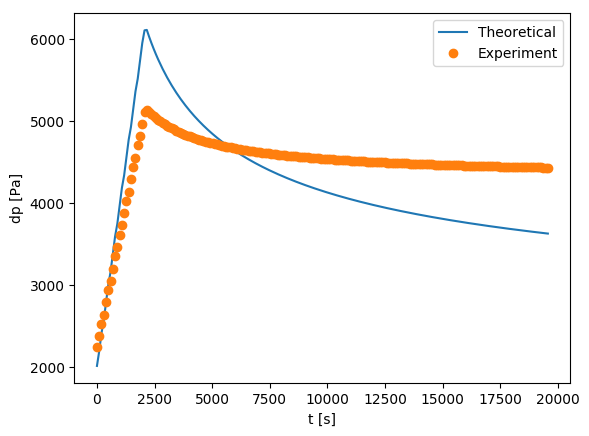

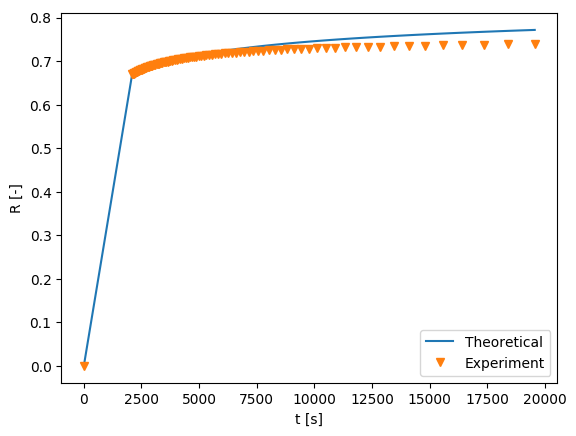

0.10322617048465445

In [83]:
x_init = paramOpt
vis_error(x_init, exp_data1, core_props, fluids, core_flood)
error_calc(x_init, exp_data1, core_props, fluids, core_flood)

# Low-sal water flooding

# Low-sal water flooding with adsorption

In [29]:
find(rand(100).>0.8)[1]

13

# Fitting the rel-perm curves

In [1]:
import Optim

In [11]:
res = Optim.optimize(x->sin(x), 0.1, 7.0, Optim.GoldenSection())

Results of Optimization Algorithm
 * Algorithm: Golden Section Search
 * Search Interval: [0.100000, 7.000000]
 * Minimizer: 4.712389e+00
 * Minimum: -1.000000e+00
 * Iterations: 36
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 37

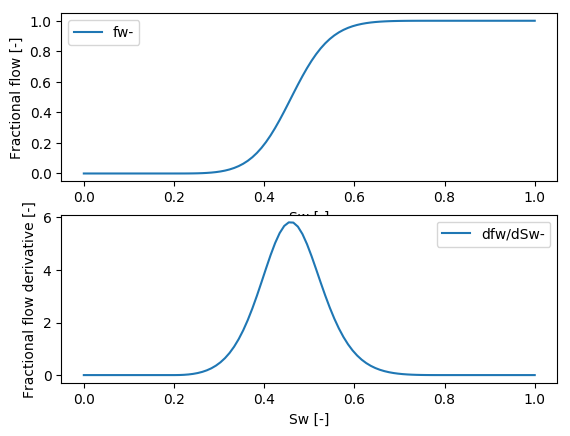

PyObject <matplotlib.legend.Legend object at 0x7f15558edb50>

In [38]:
rel_perm_param=[1.0, 0.8, 3, 4, 0.2, 0.2]
rel_perms2 = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
FF.visualize(rel_perms2, fluids)